In [1]:
%env SOCCERDATA_LOGLEVEL=ERROR
#%env SOCCERDATA_NOCACHE=True
#%env SOCCERDATA_NOSTORE=True
%env SOCCERDATA_DIR=/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccerdata

env: SOCCERDATA_LOGLEVEL=ERROR
env: SOCCERDATA_DIR=/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccerdata


# Exploratory data analysis on FBref shots

This notebook performs an exploratory data analysis on shots and xG values scraped from FBref to support the following two hypotheses in the paper:
1. Limited sample sizes, high variances and small variations in skill between players make GAX a poor metric for measuring finishing skill.
2. Including all shots when computing GAX is incorrect and obscures finishing ability.

**requirements**

To download the FBref data, you need the latest version of the [`soccerdata` package](https://soccerdata.readthedocs.io/en/latest/).

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns

Configure data and output folders.

In [3]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = Path("results/eda")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## Load dataset

First, we'll create a dataset containing all shots from five seasons in the Big Five European leagues.

In [4]:
# Select seasons and leagues to include in the analysis
leagues = ["ENG-Premier League", "ESP-La Liga", "FRA-Ligue 1", "GER-Bundesliga", "ITA-Serie A"]
seasons = ["2017-2018", "2018-2019", "2019-2020", "2020-2021", "2021-2022"]

In [5]:
# Load data from CSV file or scrape the data
fp_fbref_shots = DATA_DIR / "fbref_shots.csv"
if fp_fbref_shots.exists():
    df_shots_fbref = pd.read_csv(fp_fbref_shots)
    df_shots_fbref = df_shots_fbref.loc[~df_shots_fbref.league.isna()]
else:
    import soccerdata as sd
    
    fbref = sd.FBref(leagues, seasons)
    df_shots_fbref = fbref.read_shot_events()
    df_shots_fbref.reset_index().to_csv(fp_fbref_shots, index=False)

In [6]:
# add a "set_piece" column
df_shots_fbref["set_piece"] = (
    df_shots_fbref['notes'].astype(str).apply(lambda x: 'Free kick' in x)
    | df_shots_fbref['player'].str.contains("(pen)"))
df_shots_fbref.replace(regex={"player": "(pen)"}, value="", inplace=True)

# add a bodypart "foot" = "left foot" or "right foot"
df_shots_fbref["body_part_alt"] = df_shots_fbref["body_part"].copy()
df_shots_fbref.loc[df_shots_fbref["body_part_alt"] == "Left Foot", "body_part_alt"] = "Foot"
df_shots_fbref.loc[df_shots_fbref["body_part_alt"] == "Right Foot", "body_part_alt"] = "Foot"

# add a "long_distance" column
df_shots_fbref["long_distance"] = (df_shots_fbref["distance"] > 25) & (df_shots_fbref["distance"] < 35)

# add a "goal" column
df_shots_fbref['goal'] = df_shots_fbref["outcome"] == "Goal"

# compute GAX
df_shots_fbref['GAX'] = df_shots_fbref["goal"] - df_shots_fbref["xG"]

# set index
df_shots_fbref["season"] = df_shots_fbref["season"].astype(int).astype(str)
df_shots_fbref = df_shots_fbref.set_index(["league", "season", "game", "team", "player"])

# show result
df_shots_fbref.head()

/tmp/ipykernel_211330/843158894.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | df_shots_fbref['player'].str.contains("(pen)"))


minute  \
league             season game                              team    player                           
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey                68   
                                                                    Aaron Ramsey                81   
                                                                    Aaron Ramsey                83   
                                                                    Aaron Ramsey              90+5   
                                                                    Alex Oxlade-Chamberlain      8   

                                                                                               xG  \
league             season game                              team    player                          
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey             0.29   
                                                                    Aaron Ramsey             0.03   
                                                                    Aaron Ramsey             0.07   
                                                                    Aaron Ramsey             0.03   
                                                                    Alex Oxlade-Chamberlain  0.04   

                                                                                             PSxG  \
league             season game                              team    player                          
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey              NaN   
                                                                    Aaron Ramsey              NaN   
                                                                    Aaron Ramsey             0.25   
                                                                    Aaron Ramsey              NaN   
                                                                    Alex Oxlade-Chamberlain   NaN   

                                                                                                outcome  \
league             season game                              team    player                                
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey             Off Target   
                                                                    Aaron Ramsey             Off Target   
                                                                    Aaron Ramsey                   Goal   
                                                                    Aaron Ramsey             Off Target   
                                                                    Alex Oxlade-Chamberlain  Off Target   

                                                                                             distance  \
league             season game                              team    player                              
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey                  9.0   
                                                                    Aaron Ramsey                  9.0   
                                                                    Aaron Ramsey                  8.0   
                                                                    Aaron Ramsey                 29.0   
                                                                    Alex Oxlade-Chamberlain      24.0   

                                                                                              body_part  \
league             season game                              team    player                                
ENG-Premier League 1718   2017-08-11 Arsenal-Leicester City Arsenal Aaron Ramsey                   Head   
                                                                    Aaron Ramsey                   Head   
                                               

## H1: Limited sample sizes, high variances and small variations in skill between players

### Limited samples sizes

In [7]:
# players with most shots
df_shots_fbref.groupby("player").size().sort_values(ascending=False).head(n=20)

player
Cristiano Ronaldo     808
Lionel Messi          792
Robert Lewandowski    677
Mohamed Salah         658
Lorenzo Insigne       627
Harry Kane            620
Ciro Immobile         570
Edin Džeko            561
Domenico Berardi      532
Kylian Mbappé         532
Karim Benzema         520
Fabio Quagliarella    467
Andy Delort           465
Luis Suárez           458
Andrea Belotti        456
Federico Chiesa       449
Timo Werner           443
Nabil Fekir           438
Duván Zapata          437
Hakan Çalhanoğlu      432
dtype: int64

In [8]:
# players with most shots in a single seasons
shots_per_season = df_shots_fbref.groupby(["player", "season"]).size()
shots_per_season.sort_values(ascending=False).head(n=20)

player              season
Cristiano Ronaldo   1920      195
Lionel Messi        1718      193
                    2021      191
Harry Kane          1718      181
Lorenzo Insigne     1718      176
Cristiano Ronaldo   1718      174
                    1819      171
Lionel Messi        1819      165
Cristiano Ronaldo   2021      160
Robert Lewandowski  2122      156
Lionel Messi        1920      154
Edin Džeko          1718      152
Kylian Mbappé       2122      143
Mohamed Salah       1718      142
Robert Lewandowski  1819      140
Lorenzo Insigne     2021      136
João Pedro          2122      134
Mohamed Salah       1819      134
Federico Chiesa     1819      133
Robert Lewandowski  1920      133
dtype: int64

In [9]:
# players with highest GAX
df_shots_fbref['count'] = 1
df = df_shots_fbref.groupby("player").agg({'GAX': 'mean', 'count':'sum'})
df[df['count'] > 200].sort_values(ascending=False, by="GAX").head(n=10)#.index.values

,GAX,count
player,,
Son Heung-min,0.059267,382
Nils Petersen,0.056569,204
Riyad Mahrez,0.050511,313
Luis Muriel,0.049180,317
Dries Mertens,0.048052,385
Iago Aspas,0.046547,362
Martin Terrier,0.045830,235
Ruslan Malinovskyi,0.045721,201
James Ward-Prowse,0.045149,202


In [10]:
more_than_50shots = ((shots_per_season > 50).groupby("season").sum() / shots_per_season.groupby("season").size()).mean()
print(f"Only {more_than_50shots:.2%} of players take more than 50 shots in a season.")

Only 8.63% of players take more than 50 shots in a season.


In [11]:
conversion_pct = df_shots_fbref.goal.sum() / len(df_shots_fbref)
print(f"About {conversion_pct:.2%} of shots are converted.")

About 10.78% of shots are converted.


/tmp/ipykernel_211330/2098115748.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd['right'].set_xticklabels(["2017/18", "2018/19", "2019/20", "2020/21", "2021/22"])


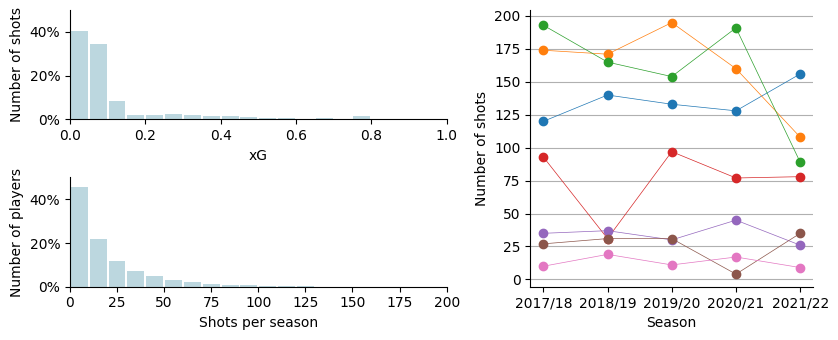

In [12]:
from matplotlib.ticker import PercentFormatter

gs_kw = dict(width_ratios=[2, 1.5], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              gridspec_kw=gs_kw, 
                              figsize=(8.5, 3.5))

# xg dist
binwidth = 0.05
axd['upper left'].hist(df_shots_fbref.xG, bins=np.arange(0, 1 + binwidth, binwidth), density=False, rwidth=0.9, color="#bcd7df", weights=np.ones(len(df_shots_fbref)) / len(df_shots_fbref))
axd['upper left'].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axd['upper left'].set_xlabel("xG")
axd['upper left'].set_ylabel("Number of shots")
axd['upper left'].set_xlim((0, 1))
axd['upper left'].set_ylim((0, .5))

# shot volume
axd['lower left'].hist(shots_per_season, bins=np.arange(0, 201, 10), density=False, rwidth=0.9, color="#bcd7df", weights=np.ones(len(shots_per_season)) / len(shots_per_season))
axd['lower left'].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
axd['lower left'].set_xlabel("Shots per season")
axd['lower left'].set_ylabel("Number of players")
axd['lower left'].set_xlim((0, 200))
axd['lower left'].set_ylim((0, .5))


# players
axd['right'].plot(shots_per_season.loc["Robert Lewandowski"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Cristiano Ronaldo"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Lionel Messi"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Kevin De Bruyne"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Luka Modrić"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Virgil van Dijk"], '-o', lw=.5)
axd['right'].plot(shots_per_season.loc["Raphaël Varane"], '-o', lw=.5)
axd['right'].grid(axis='y')

axd['right'].set_xticklabels(["2017/18", "2018/19", "2019/20", "2020/21", "2021/22"])
axd['right'].set_xlabel("Season")
axd['right'].set_ylabel("Number of shots")

sns.despine()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "shots-xg-distribution.pdf", transparent=True)


### Poor stability

In [13]:
df_shots_fbref['count'] = 1
season_keys = ['1718', '1819', '1920', '2021', '2122']
df_gax_corr = []
for i in range(1, len(season_keys)):
    prev_season = df_shots_fbref.xs(season_keys[i-1], level="season").groupby(["team", "player"]).agg({'GAX': 'mean', 'count':'sum'})
    curr_season = df_shots_fbref.xs(season_keys[i], level="season").groupby(["team", "player"]).agg({'GAX': 'mean', 'count':'sum'})
    join = pd.merge(prev_season, curr_season, how="inner", suffixes=("_prev", "_curr"), left_index=True, right_index=True)
    df_gax_corr.append(join)
df_gax_corr = pd.concat(df_gax_corr)
df_gax_corr.head()

GAX_prev  count_prev  GAX_curr  count_curr
team   player                                                       
Alavés Burgui             0.020000          15  0.030000           8
       Carlos Vigaray    -0.070000           4 -0.020000           1
       Guillermo Maripán -0.130000           4 -0.038000          15
       Ibai Gómez         0.038868          53  0.010732          41
       Ibai Gómez ()      0.210000           1 -0.790000           1

In [14]:
from sklearn.metrics import r2_score

min_shots = 50
df = df_gax_corr[(df_gax_corr.count_prev > min_shots) & (df_gax_corr.count_curr > min_shots)]
r2_score(df["GAX_prev"], df["GAX_curr"])

-0.8298936686420142

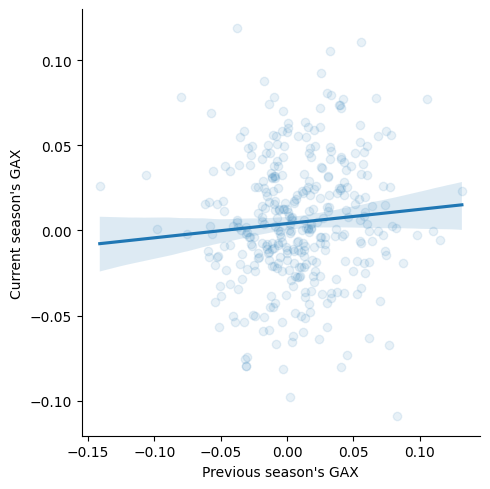

In [15]:
g = sns.lmplot(
    data=df_gax_corr[(df_gax_corr.count_prev > 50) & (df_gax_corr.count_curr > 50)], 
    x="GAX_prev", 
    y="GAX_curr", 
    scatter_kws={'alpha':0.1},
)
g.set_axis_labels("Previous season's GAX", "Current season's GAX")
plt.savefig(OUTPUT_DIR / "gax-stability.pdf", transparent=True)

## H2: Including all shots when computing GAX is incorrect and obscures finishing ability.  

### Performance on specific shot types

In [16]:
# Absolute counts of shots grouped by body part and distance
df_shots_fbref.groupby(["body_part", "long_distance"]).size()

body_part   long_distance
Head        False            39004
            True                10
Left Foot   False            54888
            True             16856
Other       False              905
            True                 1
Right Foot  False            83573
            True             29956
dtype: int64

In [17]:
# Relative counts of shots grouped by body part and distance
(df_shots_fbref.groupby(["body_part", "long_distance"]).size() / len(df_shots_fbref)).sort_values()

body_part   long_distance
Other       True             0.000004
Head        True             0.000044
Other       False            0.004019
Left Foot   True             0.074851
Right Foot  True             0.133024
Head        False            0.173203
Left Foot   False            0.243738
Right Foot  False            0.371117
dtype: float64

In [18]:
# Absolute counts of shots grouped by body part and distance for a specific player
player = "Luka Modrić"
df_shots_fbref.xs(player, level='player').groupby(["body_part", "long_distance"]).size()

body_part   long_distance
Head        False             6
Left Foot   False            33
            True             16
Right Foot  False            69
            True             49
dtype: int64

In [19]:
# How much did a specific player outperform his xG when grouped by body part and distance
df_shots_player = df_shots_fbref.xs(player, level='player')
df_shots_player.groupby(["season", "body_part"]).GAX.sum()

season  body_part 
1718    Head         -0.10
        Left Foot    -0.48
        Right Foot   -0.22
1819    Head         -0.11
        Left Foot     0.29
        Right Foot    0.14
1920    Left Foot     0.68
        Right Foot    0.76
2021    Head          0.90
        Left Foot     1.43
        Right Foot    0.36
2122    Left Foot     0.14
        Right Foot   -0.81
Name: GAX, dtype: float64

### Is Pogba good at long distance shots?

Pogba is generally considered as an excellent long-distance shooter. Can we validate this using data? Therefore, we compare how many goals Pogba scored from his shots with how many goals an average player could realisitically have scored from these shots.

In [20]:
from poibin.poibin import PoiBin

In [21]:
# select shots by Pogba
player = "Paul Pogba"
df_shots_player = df_shots_fbref.xs(player, level='player')
# remove set pieces
df_shots_player = df_shots_player[~df_shots_player["set_piece"]]

In [22]:
print(f"Seasons included: {df_shots_player.reset_index().season.unique().tolist()}")
print(f"Number of shots: {len(df_shots_player)}")
print(f"Goals scored: {df_shots_player.goal.sum()}")
print(f"Total xG: {df_shots_player.xG.sum()}")

Seasons included: ['1718', '1819', '1920', '2021', '2122']
Number of shots: 242
Goals scored: 17
Total xG: 20.85


n=242


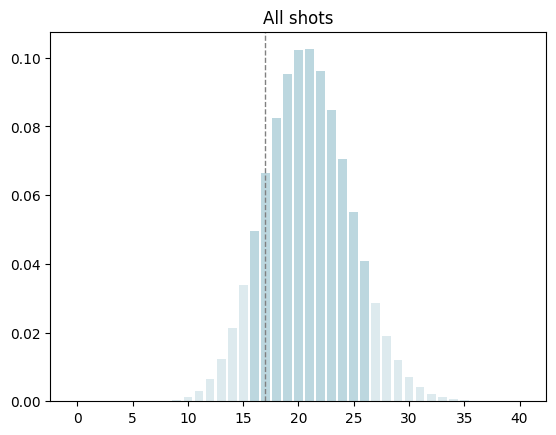

In [23]:
# defining list of r values
n=len(df_shots_player)
print(f"n={n}")
n = 40
pb = PoiBin(df_shots_player.xG)
r_values = list(range(n + 1))
# list of pmf values
dist = [pb.pmf(r) for r in r_values ]
# plotting the graph 
barlist = plt.bar(r_values, dist, color="#bcd7df")
#arlist[df_shots_player.goal.sum()].set_color('gold')
for i in range(0, np.argmax(np.cumsum(dist) >= 0.05)+1):
    barlist[i].set_alpha(.5)
for i in range(np.argmax(np.cumsum(dist) >= 0.95), n):
    barlist[i].set_alpha(.5)
plt.axvline(df_shots_player.goal.sum(), ls="--", lw = 1, color='grey')
plt.title("All shots")
plt.savefig(OUTPUT_DIR / "pogba-overall.pdf", transparent=True)
plt.show()

n=82


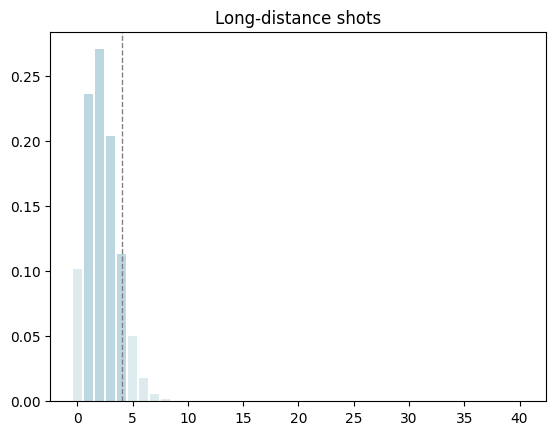

In [24]:
# defining list of r values
df = df_shots_player.loc[df_shots_player.long_distance]
n=len(df)
print(f"n={n}")
n = 40
pb = PoiBin(df.xG)
r_values = list(range(n + 1))
# list of pmf values
dist = [pb.pmf(r) for r in r_values]
# plotting the graph 
barlist = plt.bar(r_values, dist, color="#bcd7df")
#arlist[df_shots_player.goal.sum()].set_color('gold')
for i in range(0, np.argmax(np.cumsum(dist) >= 0.05)+1):
    barlist[i].set_alpha(.5)
for i in range(np.argmax(np.cumsum(dist) >= 0.95), n):
    barlist[i].set_alpha(.5)
plt.axvline(df.goal.sum(), ls="--", lw = 1, color='grey')
plt.title("Long-distance shots")
plt.savefig(OUTPUT_DIR / "pogba-longrange.pdf", transparent=True)
plt.show()

season=('1718',) / n=29


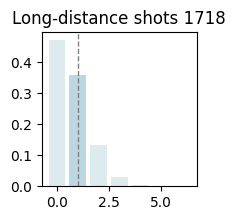

season=('1819',) / n=33


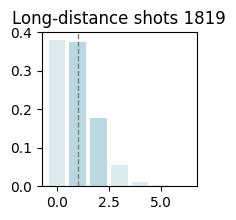

season=('1920',) / n=6


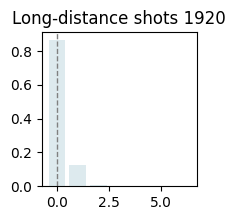

season=('2021',) / n=8


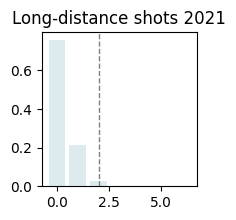

season=('2122',) / n=6


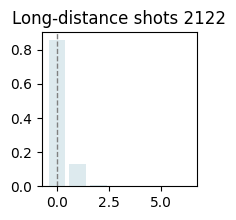

In [25]:
# defining list of r values
n=6
for season, df in df_shots_player.loc[df_shots_player.long_distance].groupby(["season"]):
    pb = PoiBin(df.xG)
    #n = int(len(df) / 4)
    print(f"season={season} / n={len(df)}")
    r_values = list(range(n + 1))
    # list of pmf values
    dist = [pb.pmf(r) for r in r_values ]
    # plotting the graph 
    plt.figure(figsize=(2,2))
    barlist = plt.bar(r_values, dist, color="#bcd7df")
    #barlist[df.goal.sum()].set_color('gold')
    for i in range(0, np.argmax(np.cumsum(dist) >= 0.05)+1):
        barlist[i].set_alpha(.5)
    for i in range(np.argmax(np.cumsum(dist) >= 0.95), n):
        barlist[i].set_alpha(.5)
    plt.axvline(df.goal.sum(), ls="--", lw = 1, color='grey')
    plt.title(f"Long-distance shots {season[0]}")
    plt.savefig(OUTPUT_DIR / f"pogba-longrange-{season}.pdf", transparent=True)
    plt.show()

Indeed, when focusing on long-distance shots (25 - 35 yards from goal), Pogba statistically outperforms his cumulative xG. However, when looking at these figures season-by-season, we can no longer draw conclusions on overperformance due to the limited sample sizes. Ultimately, drawing conclusions on over- or underperformance in specific shot categories is only feasible for exceptionally high-volume shooters over an extended period of time. 

### What is the effect of deflected shots on a player's GAX?

Overall, few shots are deflected. Nevertheless, they can have a significant effect on the figure of individual players, even those with high shot volumes. As an example, we consider the shots taken by Riyad Mahrez during the 2017/18 – 2021/22 seasons and evaluate the effect of deflected shots on his performance.

In [26]:
# Number of deflected shots
df_shots_fbref['deflected'] = df_shots_fbref.notes.astype(str).apply(lambda x: 'Deflected' in x)
deflection_pct = df_shots_fbref['deflected'].mean()
print(f"About {deflection_pct:.2%} of shots are deflected.")

About 2.31% of shots are deflected.


In [27]:
# which players have a lot of deflected shots?
df_shots_fbref.loc[df_shots_fbref.deflected].groupby('player').size().sort_values(ascending=False).head(n=10)

player
Cristiano Ronaldo    27
Son Heung-min        19
Alassane Pléa        19
Riyad Mahrez         18
Edin Džeko           18
Wilfried Zaha        17
Kevin De Bruyne      16
Gonzalo Higuaín      16
Lionel Messi         16
Romelu Lukaku        16
dtype: int64

In [28]:
# what is the effect of deflected shots on a players GAX?
player = "Riyad Mahrez"
df_shots_player = df_shots_fbref.xs(player, level='player')
# remove set pieces
df_shots_player = df_shots_player[~df_shots_player["set_piece"]]

In [29]:
print(f"Seasons included: {df_shots_player.reset_index().season.unique().tolist()}")
print(f"Number of shots: {len(df_shots_player)}")
print(f"Pct of shots deflected: {df_shots_player.deflected.sum() / len(df_shots_player):.2f}")
print(f"Goals scored: {df_shots_player.goal.sum()}")
print(f"Total xG: {df_shots_player.xG.sum()}")

Seasons included: ['1718', '1819', '1920', '2021', '2122']
Number of shots: 289
Pct of shots deflected: 0.06
Goals scored: 42
Total xG: 27.39


goals=42, xg=27.39, GAX=14.61


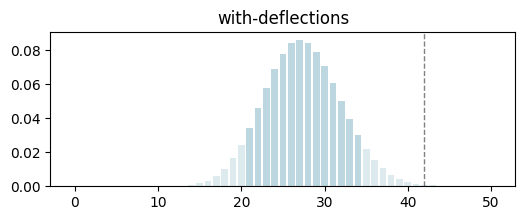

goals=35, xg=25.97, GAX=9.030000000000001


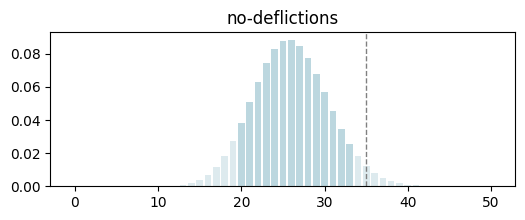

In [31]:
n=200
for name, df in zip(["with-deflections", "no-deflictions"], [df_shots_player, df_shots_player.loc[~df_shots_player.deflected]]):
    pb = PoiBin(df.xG)
    n = int(len(df) / 4)
    n = 50
    print(f"goals={df.goal.sum()}, xg={df.xG.sum()}, GAX={df.goal.sum() - df.xG.sum()}")
    r_values = list(range(n + 1))
    # list of pmf values
    dist = [pb.pmf(r) for r in r_values ]
    # plotting the graph 
    plt.figure(figsize=(6,2))
    barlist = plt.bar(r_values, dist, color="#bcd7df")
    #barlist[df.goal.sum()].set_color('gold')
    for i in range(0, np.argmax(np.cumsum(dist) >= 0.05)+1):
        barlist[i].set_alpha(.5)
    for i in range(np.argmax(np.cumsum(dist) >= 0.95), n):
        barlist[i].set_alpha(.5)
    plt.axvline(df.goal.sum(), ls="--", lw = 1, color='grey')
    plt.title(name)
    plt.savefig(OUTPUT_DIR / f"mahrez-{name}.pdf", transparent=True)
    plt.show()